# Blood Sample Classification Model

This notebook implements a step-by-step approach to build a blood sample classification model. We'll focus on a single robust model with careful data preprocessing.

## Overview of Steps:
1. Import required libraries
2. Load and explore data
3. Preprocess the data
4. Feature selection
5. Build model
6. Generate and save predictions

The goal is to classify blood samples into different disease categories based on blood marker measurements.

In [1]:
# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

LOADING AND EXPLORING DATA
Training data shape: (2351, 25)
Testing data shape: (486, 25)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null  

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes
2,0.452539,0.116135,0.544560,0.400640,0.294538,0.382021,0.625267,0.295122,0.868369,0.026808,...,0.466795,0.387332,0.421763,0.007186,0.506918,0.431704,0.417295,0.799074,0.779208,Thalasse
3,0.136609,0.015605,0.419957,0.191487,0.081168,0.166214,0.073293,0.668719,0.125447,0.501051,...,0.016256,0.040137,0.826721,0.265415,0.594148,0.225756,0.490349,0.637061,0.354094,Anemia
4,0.176737,0.752220,0.971779,0.785286,0.443880,0.439851,0.894991,0.442159,0.257288,0.805987,...,0.429431,0.146294,0.221574,0.015280,0.567115,0.841412,0.153350,0.794008,0.094970,Thalasse



Target variable distribution:
Disease
Anemia      623
Healthy     556
Diabetes    540
Thalasse    509
Thromboc    123
Name: count, dtype: int64


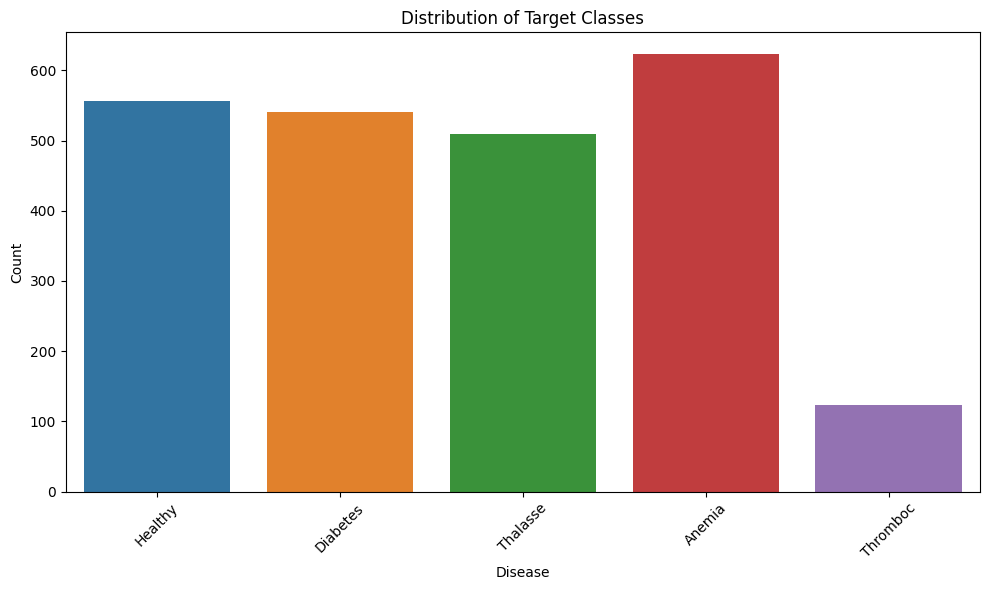


Missing values in training data:
0

Missing values in test data:
0


In [2]:
# Step 2: Load and Explore Data
print("="*50)
print("LOADING AND EXPLORING DATA")
print("="*50)

train = pd.read_csv("/kaggle/input/blood-samples/Blood_samples_dataset_balanced_2(f).csv")
test = pd.read_csv("/kaggle/input/blood-samples/blood_samples_dataset_test.csv")


print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")

print("\nTraining data info:")
train.info()

print("\nFirst few rows of training data:")
display(train.head())

if 'Disease' in train.columns:
    target_col = 'Disease'
elif 'label' in train.columns:
    target_col = 'label'
else:
    target_col = train.columns[-1]
    print(f"Assuming target column is: {target_col}")

print("\nTarget variable distribution:")
target_counts = train[target_col].value_counts()
print(target_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x=target_col, data=train)
plt.title('Distribution of Target Classes')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nMissing values in training data:")
print(train.isnull().sum().sum())

print("\nMissing values in test data:")
print(test.isnull().sum().sum())

In [3]:
# Step 3: Preprocess the Data
print("="*50)
print("DATA PREPROCESSING")
print("="*50)

X = train.drop(target_col, axis=1)
y = train[target_col]

X_test = test.copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")

if target_col in X_test.columns:
    print(f"Removing {target_col} from test data")
    X_test = X_test.drop(target_col, axis=1)
    print(f"Test features shape after removing target: {X_test.shape}")

print(f"\nTraining features: {list(X.columns)[:5]}... (and {len(X.columns)-5} more)")
print(f"Test features: {list(X_test.columns)[:5]}... (and {len(X_test.columns)-5} more)")

missing_in_test = set(X.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X.columns)

if missing_in_test:
    print(f"Features missing in test: {missing_in_test}")
    for col in missing_in_test:
        X_test[col] = 0

if missing_in_train:
    print(f"Features missing in train: {missing_in_train}")
    X_test = X_test.drop(columns=missing_in_train)

X_test = X_test[X.columns]

print(f"\nAligned shapes - Train: {X.shape}, Test: {X_test.shape}")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nTarget classes: {label_encoder.classes_}")
print(f"Encoded target distribution: {np.bincount(y_encoded)}")

if X.isnull().sum().sum() > 0:
    print("Filling missing values in training data...")
    X = X.fillna(X.median())
    
if X_test.isnull().sum().sum() > 0:
    print("Filling missing values in test data...")
    X_test = X_test.fillna(X_test.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaled features shape: {X_scaled.shape}")
print(f"Scaled test features shape: {X_test_scaled.shape}")

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nTraining set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val_split.shape[0]} samples")

DATA PREPROCESSING
Features shape: (2351, 24)
Target shape: (2351,)
Test features shape: (486, 25)
Removing Disease from test data
Test features shape after removing target: (486, 24)

Training features: ['Glucose', 'Cholesterol', 'Hemoglobin', 'Platelets', 'White Blood Cells']... (and 19 more)
Test features: ['Glucose', 'Cholesterol', 'Hemoglobin', 'Platelets', 'White Blood Cells']... (and 19 more)

Aligned shapes - Train: (2351, 24), Test: (486, 24)

Target classes: ['Anemia' 'Diabetes' 'Healthy' 'Thalasse' 'Thromboc']
Encoded target distribution: [623 540 556 509 123]

Scaled features shape: (2351, 24)
Scaled test features shape: (486, 24)

Training set: 1880 samples
Validation set: 471 samples


In [4]:
# Step 4: Feature Selection
print("="*50)
print("FEATURE SELECTION")
print("="*50)

print("Calculating feature variances...")

feature_variance = pd.DataFrame({
    'feature': X.columns,
    'variance': np.var(X_scaled, axis=0)
}).sort_values('variance', ascending=True)

print("\nFeatures with lowest variance:")
print(feature_variance.head(5))

print("\nFeatures with highest variance:")
print(feature_variance.tail(5))

low_var_threshold = feature_variance['variance'].quantile(0.05)
high_var_threshold = feature_variance['variance'].quantile(0.95)

selected_features = feature_variance[
    (feature_variance['variance'] > low_var_threshold) & 
    (feature_variance['variance'] < high_var_threshold)
]['feature'].tolist()

print(f"\nSelected {len(selected_features)} features with reasonable variance")

X_selected = X[selected_features]
X_test_selected = X_test[selected_features]

scaler_selected = StandardScaler()
X_selected_scaled = scaler_selected.fit_transform(X_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

print(f"\nSelected features shape: {X_selected_scaled.shape}")
print(f"Selected test features shape: {X_test_selected_scaled.shape}")

X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(
    X_selected_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

key_biological_markers = [
    'Hemoglobin',
    'Red Blood Cells',
    'White Blood Cells',
    'Platelets',
    'Glucose',
    'HbA1c',
    'Insulin'
]

print("\nKey biological markers:")
for marker in key_biological_markers:
    if marker in selected_features:
        print(f"✓ {marker} - included in selected features")
    else:
        print(f"✗ {marker} - NOT included in selected features")

FEATURE SELECTION
Calculating feature variances...

Features with lowest variance:
              feature  variance
0             Glucose       1.0
21         Creatinine       1.0
20         Heart Rate       1.0
19                AST       1.0
4   White Blood Cells       1.0

Features with highest variance:
                                      feature  variance
7                     Mean Corpuscular Volume       1.0
15                                      HbA1c       1.0
5                             Red Blood Cells       1.0
16                            LDL Cholesterol       1.0
9   Mean Corpuscular Hemoglobin Concentration       1.0

Selected 17 features with reasonable variance

Selected features shape: (2351, 17)
Selected test features shape: (486, 17)

Key biological markers:
✓ Hemoglobin - included in selected features
✓ Red Blood Cells - included in selected features
✗ White Blood Cells - NOT included in selected features
✓ Platelets - included in selected features
✗ Glucose - 

BUILDING THE MODEL
Creating Random Forest model...
Training the model...

Evaluating model on validation set...
Validation accuracy: 1.0000

Confusion matrix:


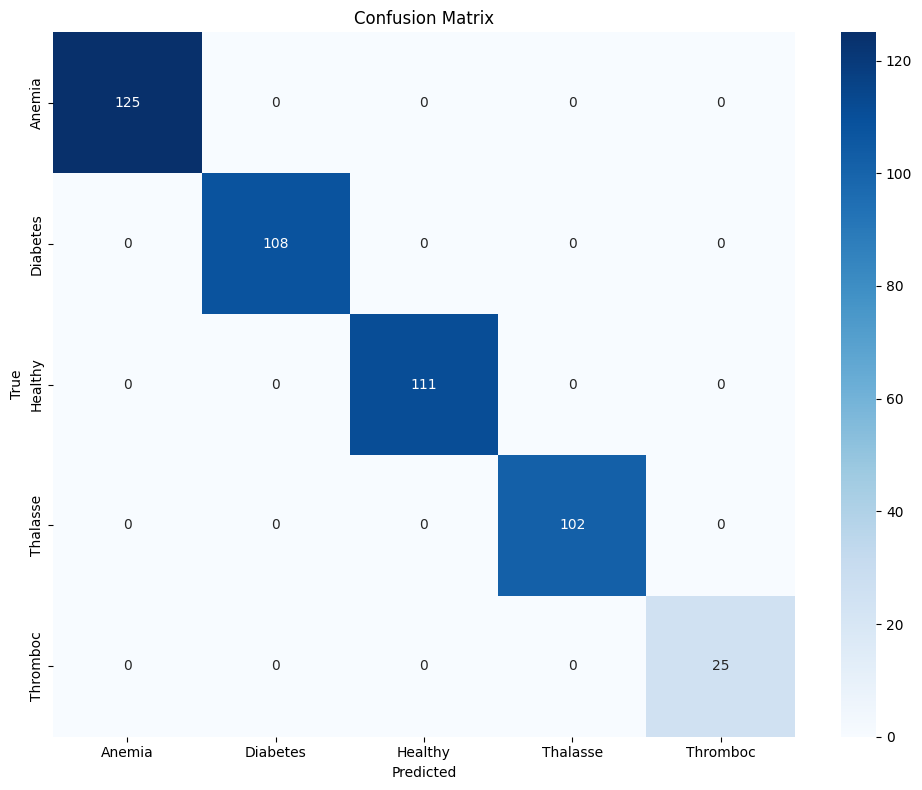


Classification report:
              precision    recall  f1-score   support

      Anemia       1.00      1.00      1.00       125
    Diabetes       1.00      1.00      1.00       108
     Healthy       1.00      1.00      1.00       111
    Thalasse       1.00      1.00      1.00       102
    Thromboc       1.00      1.00      1.00        25

    accuracy                           1.00       471
   macro avg       1.00      1.00      1.00       471
weighted avg       1.00      1.00      1.00       471


Top 10 most important features:
                        feature  importance
6   Mean Corpuscular Hemoglobin    0.142978
16              Red Blood Cells    0.101044
7                    Hematocrit    0.095871
8                     Platelets    0.080836
1               HDL Cholesterol    0.062199
3                      Troponin    0.058197
10                  Cholesterol    0.050914
14      Mean Corpuscular Volume    0.049921
13     Diastolic Blood Pressure    0.047548
0             

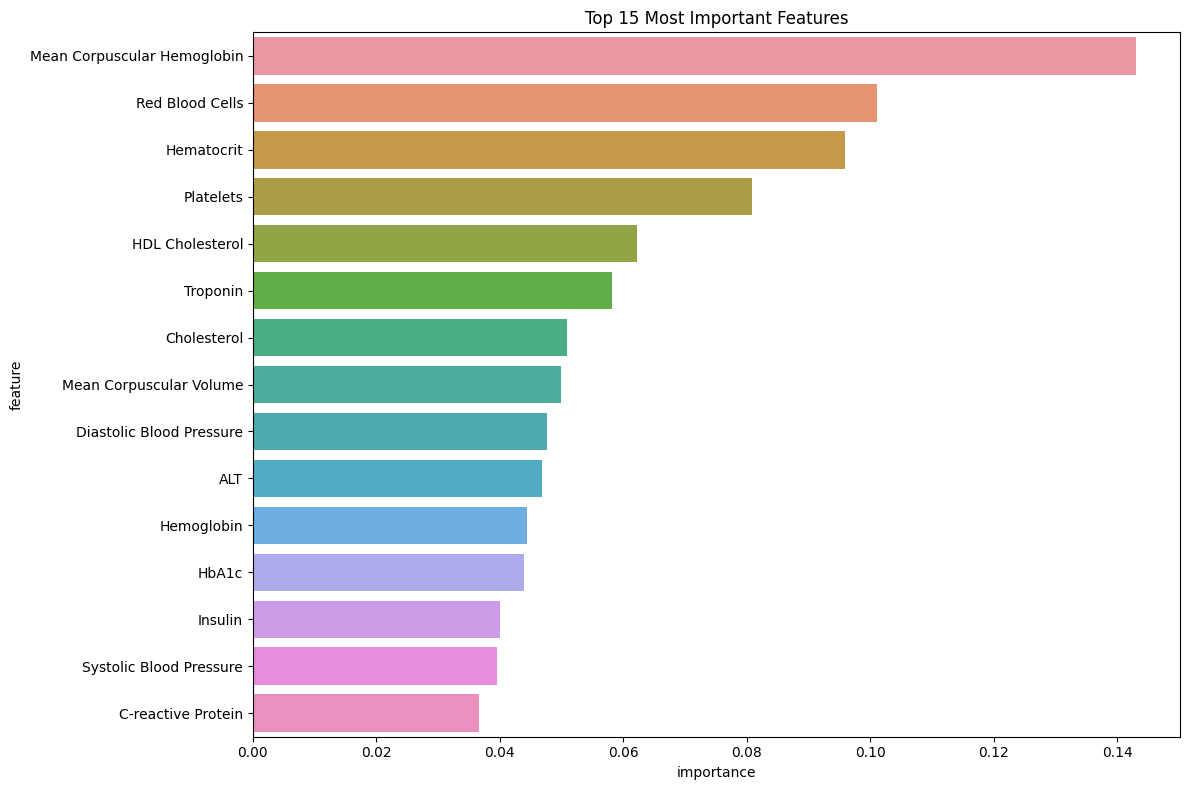


Training final model on full dataset...


RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=10,
                       n_jobs=-1, random_state=42)

In [5]:
# Step 5: Build Model
print("="*50)
print("BUILDING THE MODEL")
print("="*50)

print("Creating Random Forest model...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

print("Training the model...")
rf_model.fit(X_train_selected, y_train_selected)

print("\nEvaluating model on validation set...")
val_preds = rf_model.predict(X_val_selected)
val_accuracy = accuracy_score(y_val_selected, val_preds)
print(f"Validation accuracy: {val_accuracy:.4f}")

print("\nConfusion matrix:")
conf_matrix = confusion_matrix(y_val_selected, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nClassification report:")
print(classification_report(y_val_selected, val_preds, target_names=label_encoder.classes_))

print("\nTop 10 most important features:")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

print("\nTraining final model on full dataset...")
rf_model_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_model_final.fit(X_selected_scaled, y_encoded)

GENERATING AND SAVING PREDICTIONS
Making predictions on test data...

Predicted class distribution:
Diabetes    218
Anemia      107
Healthy      87
Thalasse     72
Thromboc      2
Name: count, dtype: int64


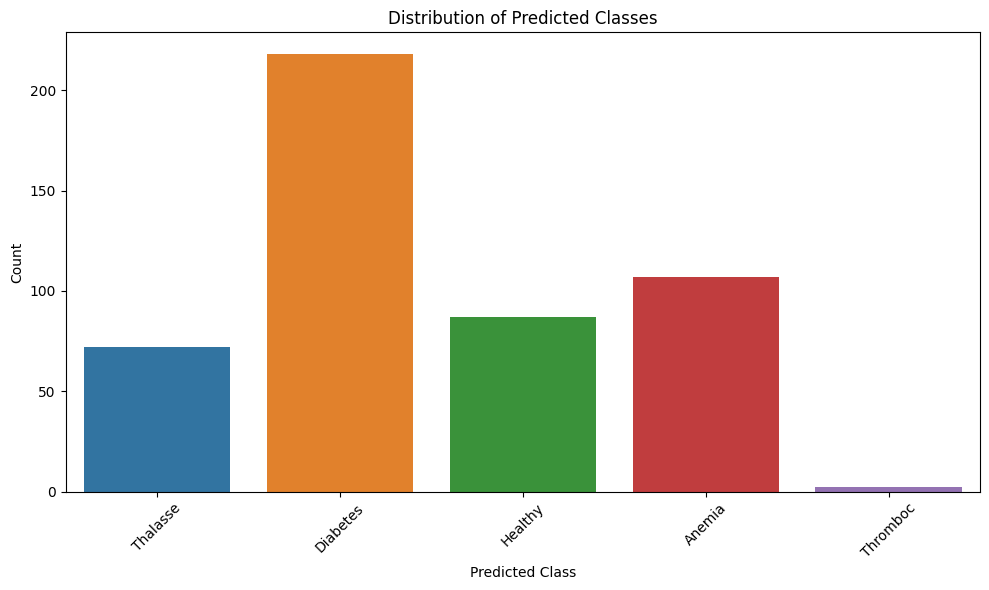


Submission saved to submission_rf_model.csv

First few rows of the submission file:


,id,label
0,1,Thalasse
1,2,Diabetes
2,3,Healthy
3,4,Anemia
4,5,Healthy
5,6,Healthy
6,7,Diabetes
7,8,Healthy
8,9,Diabetes
9,10,Diabetes


In [6]:
# Step 6: Generate and Save Predictions
print("="*50)
print("GENERATING AND SAVING PREDICTIONS")
print("="*50)

print("Making predictions on test data...")
test_preds = rf_model_final.predict(X_test_selected_scaled)

test_preds_labels = label_encoder.inverse_transform(test_preds)

pred_counts = pd.Series(test_preds_labels).value_counts()
print("\nPredicted class distribution:")
print(pred_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(test_preds_labels))
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

submission = pd.DataFrame({
    'id': range(1, len(test_preds_labels) + 1),
    'label': test_preds_labels
})

submission.to_csv("submission_rf_model.csv", index=False)
print("\nSubmission saved to submission_rf_model.csv")


print("\nFirst few rows of the submission file:")
display(submission.head(10))

# Conclusion

This notebook demonstrated a straightforward approach to building a blood sample classification model. We followed these key steps:

1. **Data Loading and Exploration**: Understanding the structure and characteristics of our data
2. **Preprocessing**: Ensuring consistent features, handling missing values, and scaling
3. **Feature Selection**: Identifying and selecting features with reasonable variance
4. **Model Building**: Creating a robust Random Forest model
5. **Prediction Generation**: Applying the model to test data and saving results

The Random Forest model was chosen for its balance of performance and interpretability. It naturally handles non-linear relationships, provides feature importance, and is less prone to overfitting than some other models.

The complete pipeline enables us to go from raw blood sample data to disease classifications in a systematic way.